In [278]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)



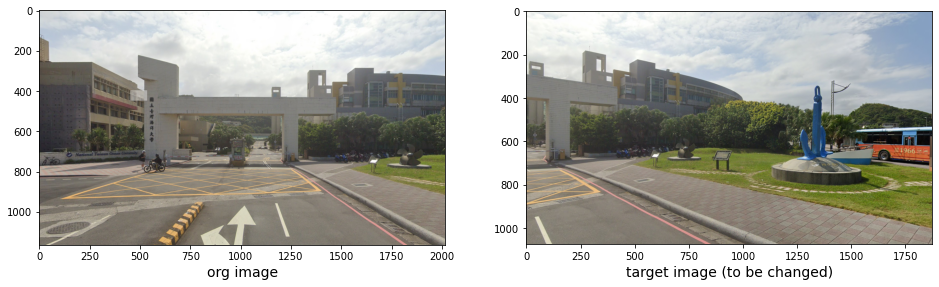

In [279]:
# 讀入照片並轉為黑白的
# (train image)這是會被根據另一張而被調整的影像
targetImg = imageio.imread('NTOU R.png')
#灰色的
targetImg_g = cv2.cvtColor(targetImg, cv2.COLOR_RGB2GRAY)

orgImg = imageio.imread('NTOU L.png')
orgImg_g = cv2.cvtColor(orgImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(orgImg, cmap="gray")
ax1.set_xlabel("org image", fontsize=14)

ax2.imshow(targetImg, cmap="gray")
ax2.set_xlabel("target image (to be changed)", fontsize=14)

plt.show()


In [280]:
'''
取出兩張照片的特徵
'''
# 得到關鍵點和描述子
descriptor = cv2.BRISK_create()
kpsA, featuresA = descriptor.detectAndCompute(targetImg_g, None)
kpsB, featuresB = descriptor.detectAndCompute(orgImg_g, None)


In [281]:
'''
根據兩張照片的特徵去做相關
'''
def matchKeyPoints(featuresA, featuresB):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # 找出對應的描述子
    best_matches = bf.match(featuresA,featuresB)
    
    # 用他們相似度(值的距離)去排序
    # 較相似的排前面
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("特徵點相連數:", len(rawMatches))
    return rawMatches



特徵點相連數: 1365


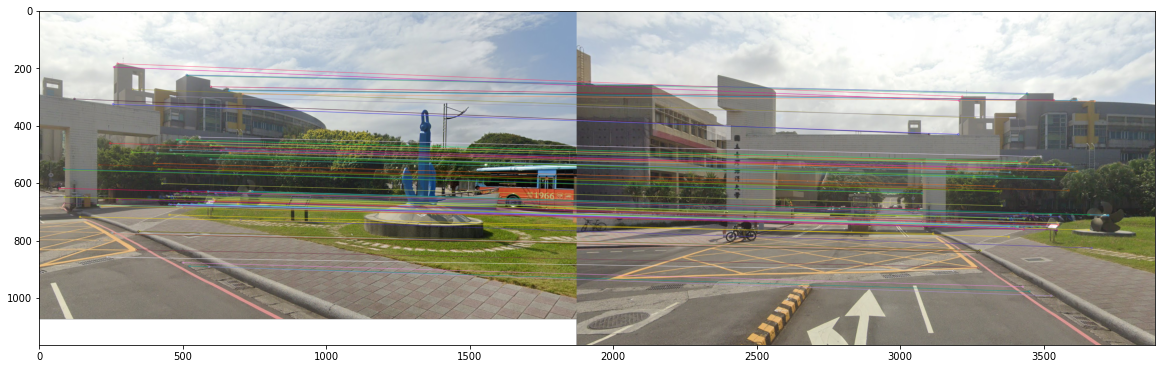

In [282]:
'''
把對應的相似點秀出來
'''

fig = plt.figure(figsize=(20,8))

matches = matchKeyPoints(featuresA, featuresB)
img3 = cv2.drawMatches(targetImg,kpsA,orgImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(img3)
plt.show()

In [283]:
'''
計算多個 二維數對 之間的映射轉換矩陣
'''
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # 把關鍵點轉換成np的陣列
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        # 把兩組建起來
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        # 估算轉換矩陣
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [284]:
#得到轉換矩陣
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
(matches, H, status) = M

In [285]:
'''
全景校正
'''
width = targetImg.shape[1] + orgImg.shape[1]
height = targetImg.shape[0] + orgImg.shape[0]
#利用warpPerspective去做視角校正
result = cv2.warpPerspective(targetImg, H, (width, height))
result[0:orgImg.shape[0], 0:orgImg.shape[1]] = orgImg

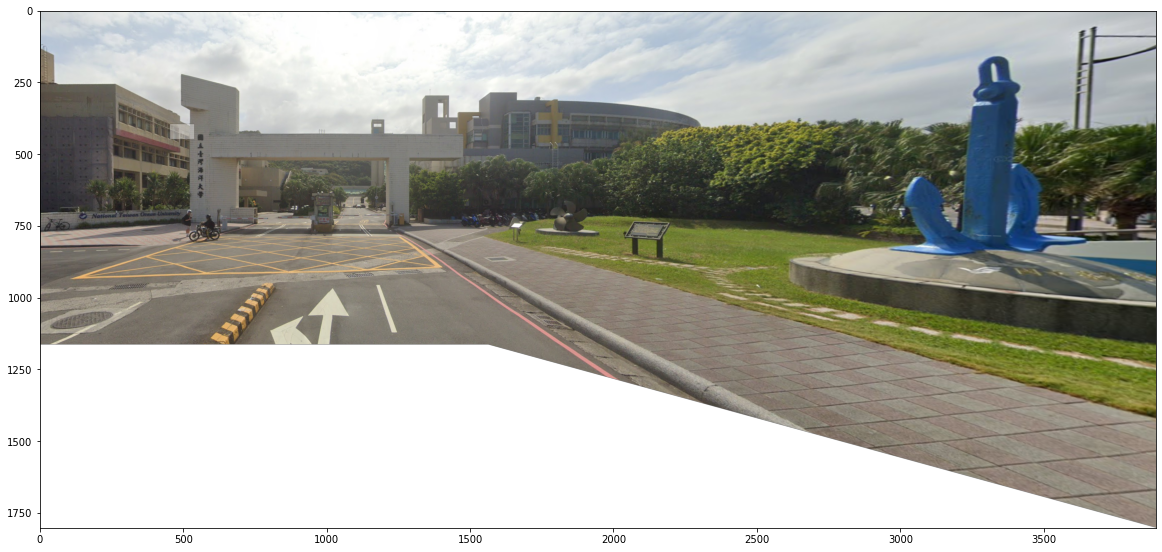

In [286]:
# 轉成二值化影像
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# 找到最大等值區域
c = max(cnts, key=cv2.contourArea)

# 把有值的地方找出來
(x, y, w, h) = cv2.boundingRect(c)

# 把有影像的地方切出來
result = result[y:y + h, x:x + w]

#秀出最終圖片
plt.figure(figsize=(20,10))
plt.imshow(result)


